In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier
from joblib import load

from config import EXPERIMENT, RUN_NAME, ARTIFACT_DIR
from logger import logger
from mlflow_utils import evaluate_binary, log_mlflow

In [3]:
# Tag this cell as 'parameters'
INDEX = 'SNP'

In [4]:
# Parameters
INDEX = "HANGSENG"


In [5]:
# Wrap all this is a parameter dict
run_params = {'experiment': EXPERIMENT,
              'iteration': RUN_NAME,
              'index': INDEX,
              'artifact_dir': ARTIFACT_DIR}

### Import data

In [6]:
df = pd.read_csv('../datadir/{}.csv'.format(INDEX))

### Data prep

In [7]:
df.columns = [col.lower().replace(' ', '_') for col in df.columns]

In [8]:
df.sort_values(by='date', ascending=True, inplace=True)  # Have to sort ascending for rolling to work correctly

### Create basic features

In [9]:
df = df[['date', 'open', 'adj_close']].copy()

In [10]:
df['prev'] = df['adj_close'].shift(1)

In [11]:
df['sma2'] = df['prev'].rolling(window=2).mean()
df['sma5'] = df['prev'].rolling(window=5).mean()
df['sma10'] = df['prev'].rolling(window=10).mean()
df['sma20'] = df['prev'].rolling(window=20).mean()

In [12]:
assert round(df['prev'].tail(5).mean(), 4) == round(df['sma5'].tail(1).item(), 4), 'Expected sma5 to be same as mean of past 5 items'
assert round(df['prev'].tail(10).mean(), 4) == round(df['sma10'].tail(1).item(), 4), 'Expected sma10 to be same as mean of past 10 items'
assert round(df['prev'].tail(20).mean(), 4) == round(df['sma20'].tail(1).item(), 4), 'Expected sma20 to be same as mean of past 20 items'

In [13]:
df['ema12'] = df['prev'].ewm(span=12, min_periods=12, adjust=False).mean()
df['ema26'] = df['prev'].ewm(span=26, min_periods=26, adjust=False).mean()

In [14]:
def difference(prev_price, moving_average):
    return (prev_price - moving_average) / prev_price

In [15]:
for col in ['sma2', 'sma5', 'sma10', 'sma20', 'ema12', 'ema26']:
    df['{}_diff'.format(col)] = difference(df['prev'], df[col])

In [16]:
df.dropna(inplace=True)

In [17]:
df.shape

(223, 16)

In [18]:
df.drop(columns=['date', 'open'], inplace=True)

### Create label

In [19]:
df['label'] = (df['adj_close'] > df['prev']).astype(int)

### Train-val split

In [20]:
# Keep most recent 20 days as validation set

In [21]:
validation_days = 20
train = df.iloc[:-validation_days].copy()
val = df.iloc[-validation_days:].copy()
logger.info('No. of days - Train: {}, Val: {}'.format(train.shape[0], val.shape[0]))

[05/Dec/2021 00:45:35] INFO - No. of days - Train: 203, Val: 20


### Basic visualizations

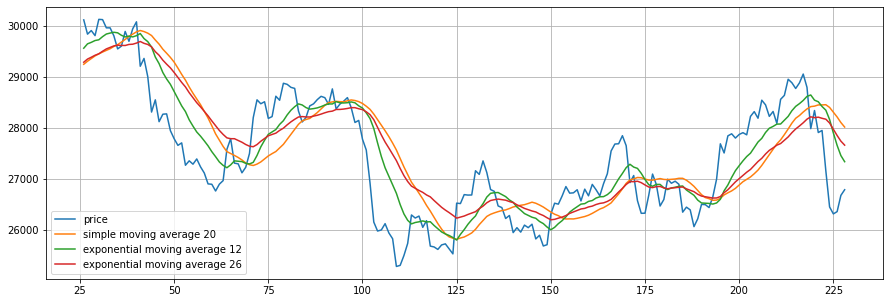

In [22]:
plt.figure(figsize=(15, 5))
plt.grid()
plt.plot(train['adj_close'], label='price')
plt.plot(train['sma20'], label='simple moving average 20')
plt.plot(train['ema12'], label='exponential moving average 12')
plt.plot(train['ema26'], label='exponential moving average 26')
plt.legend()

### Feature transformations

In [23]:
scaler = StandardScaler()

In [24]:
COLS_TO_SCALE = ['prev', 'sma2', 'sma5', 'sma10', 'sma20', 'ema12', 'ema26']

In [25]:
scaler.fit(train[COLS_TO_SCALE])

StandardScaler()

In [26]:
train[COLS_TO_SCALE] = scaler.transform(train[COLS_TO_SCALE])
val[COLS_TO_SCALE] = scaler.transform(val[COLS_TO_SCALE])

### Linear regression coefficients

In [27]:
x_variables = '+'.join(list(train.columns[1:-1]))
logger.info('x variables: {}'.format(x_variables))

[05/Dec/2021 00:45:37] INFO - x variables: prev+sma2+sma5+sma10+sma20+ema12+ema26+sma2_diff+sma5_diff+sma10_diff+sma20_diff+ema12_diff+ema26_diff


In [28]:
results = smf.ols('adj_close ~ {}'.format(x_variables), data=train).fit()

In [29]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              adj_close   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     268.3
Date:                Sun, 05 Dec 2021   Prob (F-statistic):          3.55e-114
Time:                        00:45:38   Log-Likelihood:                -1423.8
No. Observations:                 203   AIC:                             2876.
Df Residuals:                     189   BIC:                             2922.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.751e+04    130.619    210.624      0.0

### Drop label col

In [30]:
train.drop(columns=['adj_close'], inplace=True)
val.drop(columns=['adj_close'], inplace=True)

### Logistic Regression Coefficients

In [31]:
y = train['label'].values
X = train.drop(columns=['label'])

In [32]:
X = add_constant(X)

In [33]:
logit = sm.Logit(y, X)

In [34]:
result = logit.fit()
print(result.summary())

         Current function value: 7.346979
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  203
Model:                          Logit   Df Residuals:                      189
Method:                           MLE   Df Model:                           13
Date:                Sun, 05 Dec 2021   Pseudo R-squ.:                  -9.600
Time:                        00:45:40   Log-Likelihood:                -1491.4
converged:                      False   LL-Null:                       -140.71
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -81.2685     19.130     -4.248      0.000    -118.762     -43.775
prev       -2850.2138    654.893     -4.352      0.000   -4133.78

D:\Softwares\miniconda3\envs\mlops\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Train some basic models

In [35]:
y_train = train['label'].values
X_train = train.drop(columns='label').values

y_val = val['label'].values
X_val = val.drop(columns='label').values

[05/Dec/2021 00:45:41] INFO - AUC: 0.616 | Recall: 0.667 | Precision: 0.545 | F1: 0.600


[05/Dec/2021 00:45:41] INFO - ROC curve saved to: ../artifact_dir/plots/roc_curve_Logistic Regression (auc = 0.62).png


[05/Dec/2021 00:45:41] INFO - Precision-recall curve saved to: ../artifact_dir/plots/precision_recall_Logistic Regression (prec = 0.55, recall = 0.67).png


[05/Dec/2021 00:45:41] INFO - Model saved to: ../artifact_dir/models/Logistic Regression.pickle


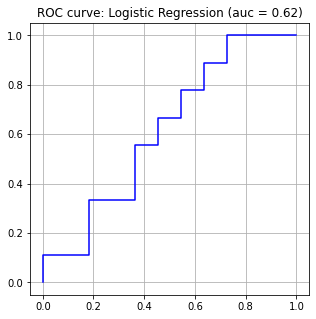

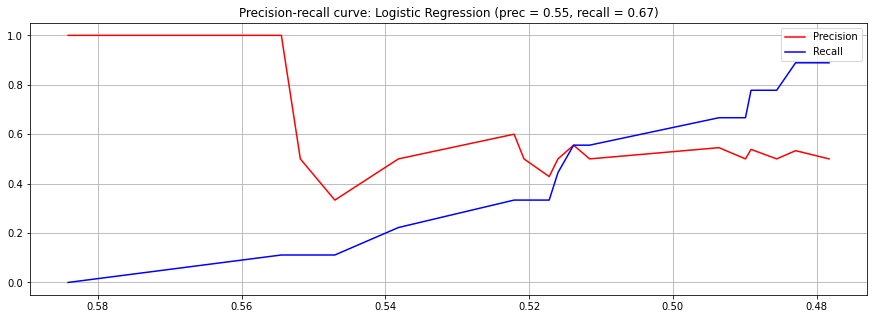

In [36]:
# Logistic regression
model_name = 'Logistic Regression'
model = LogisticRegression(fit_intercept=False).fit(X_train, y_train)
pred = model.predict_proba(X_val)[:, 1]
log_mlflow(run_params, model, model_name, y_val, pred)

[05/Dec/2021 00:45:42] INFO - AUC: 0.566 | Recall: 0.000 | Precision: 0.000 | F1: 0.000


[05/Dec/2021 00:45:42] INFO - ROC curve saved to: ../artifact_dir/plots/roc_curve_Support Vector Classifier (auc = 0.57).png


D:\Softwares\miniconda3\envs\mlops\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[05/Dec/2021 00:45:42] INFO - Precision-recall curve saved to: ../artifact_dir/plots/precision_recall_Support Vector Classifier (prec = 0.00, recall = 0.00).png


[05/Dec/2021 00:45:42] INFO - Model saved to: ../artifact_dir/models/Support Vector Classifier.pickle


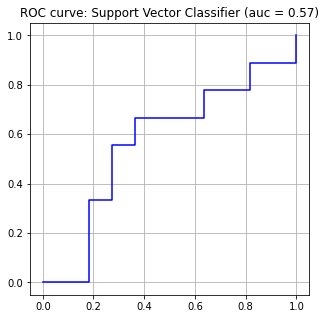

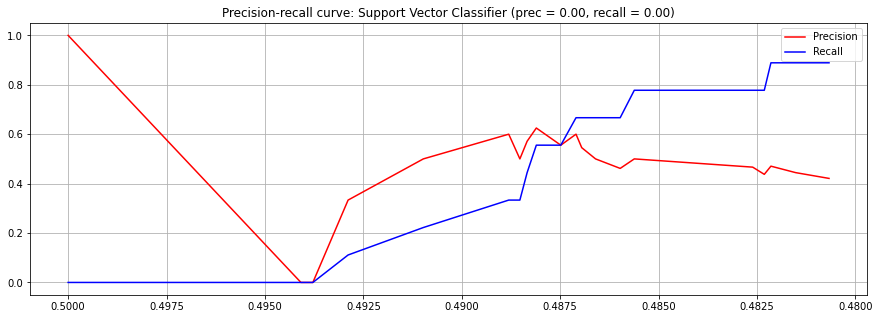

In [37]:
# Support vector classifier
model_name = 'Support Vector Classifier'
model = SVC(gamma=2, C=1, probability=True).fit(X_train, y_train)
pred = model.predict_proba(X_val)[:, 1]
log_mlflow(run_params, model, model_name, y_val, pred)

[05/Dec/2021 00:45:43] INFO - AUC: 0.480 | Recall: 0.667 | Precision: 0.375 | F1: 0.480


[05/Dec/2021 00:45:43] INFO - ROC curve saved to: ../artifact_dir/plots/roc_curve_K-nearest Neighbours (auc = 0.48).png


[05/Dec/2021 00:45:43] INFO - Precision-recall curve saved to: ../artifact_dir/plots/precision_recall_K-nearest Neighbours (prec = 0.38, recall = 0.67).png


[05/Dec/2021 00:45:43] INFO - Model saved to: ../artifact_dir/models/K-nearest Neighbours.pickle


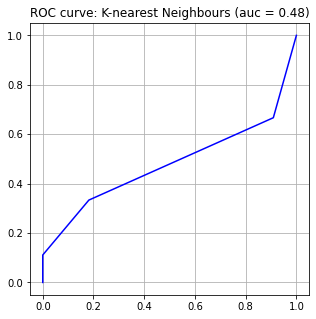

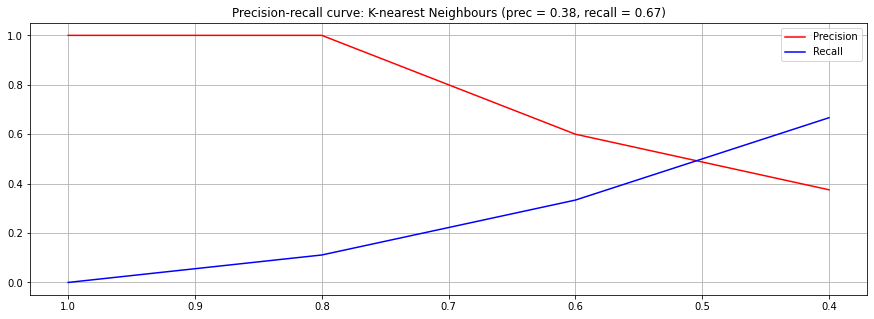

In [38]:
# K-neighbours
model_name = 'K-nearest Neighbours'
model = KNeighborsClassifier(5).fit(X_train, y_train)
pred = model.predict_proba(X_val)[:, 1]
log_mlflow(run_params, model, model_name, y_val, pred)

[05/Dec/2021 00:45:44] INFO - AUC: 0.697 | Recall: 0.667 | Precision: 0.500 | F1: 0.571


[05/Dec/2021 00:45:44] INFO - ROC curve saved to: ../artifact_dir/plots/roc_curve_Gradient Boosting Machine (auc = 0.70).png


[05/Dec/2021 00:45:44] INFO - Precision-recall curve saved to: ../artifact_dir/plots/precision_recall_Gradient Boosting Machine (prec = 0.50, recall = 0.67).png


[05/Dec/2021 00:45:44] INFO - Model saved to: ../artifact_dir/models/Gradient Boosting Machine.pickle


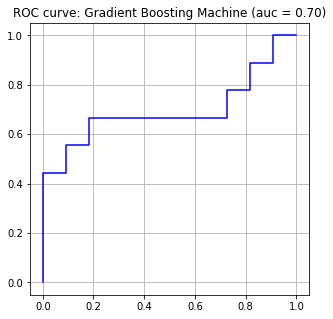

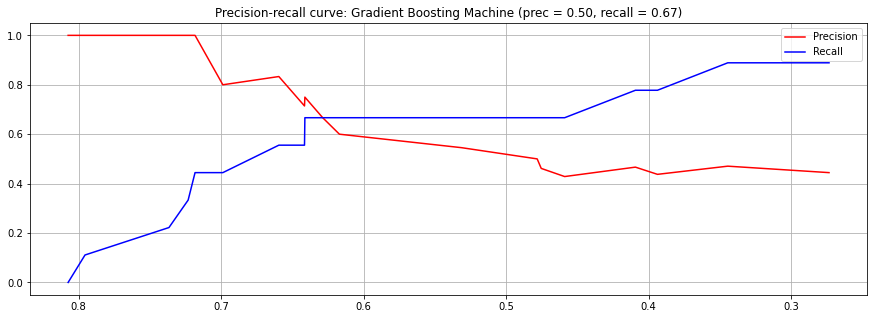

In [39]:
# Gradient Boosting
model_name = 'Gradient Boosting Machine'
model = GradientBoostingClassifier().fit(X_train, y_train)
pred = model.predict_proba(X_val)[:, 1]
log_mlflow(run_params, model, model_name, y_val, pred)

[05/Dec/2021 00:45:45] INFO - AUC: 0.338 | Recall: 0.556 | Precision: 0.357 | F1: 0.435


[05/Dec/2021 00:45:45] INFO - ROC curve saved to: ../artifact_dir/plots/roc_curve_Extra Trees (auc = 0.34).png


[05/Dec/2021 00:45:45] INFO - Precision-recall curve saved to: ../artifact_dir/plots/precision_recall_Extra Trees (prec = 0.36, recall = 0.56).png


[05/Dec/2021 00:45:45] INFO - Model saved to: ../artifact_dir/models/Extra Trees.pickle


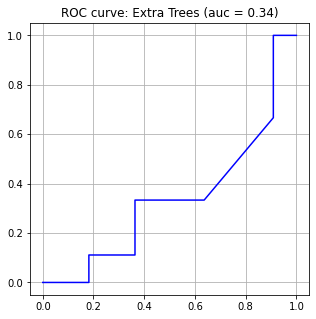

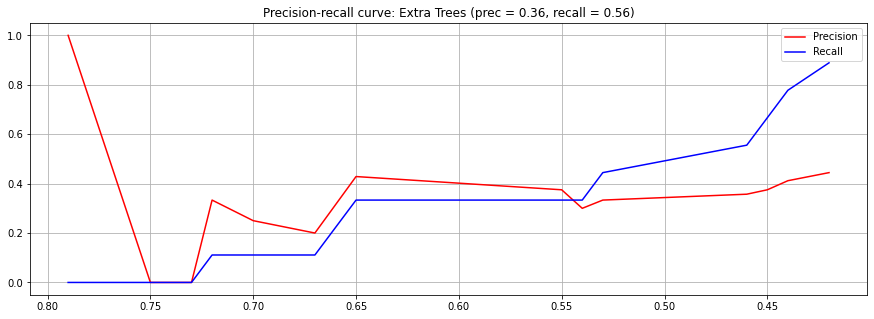

In [40]:
# Bagged trees
model_name = 'Extra Trees'
model = ExtraTreesClassifier().fit(X_train, y_train)
pred = model.predict_proba(X_val)[:, 1]
log_mlflow(run_params, model, model_name, y_val, pred)

### Test loading model

In [41]:
model_name = 'Support Vector Classifier'
check_model = load('{}/models/{}.pickle'.format(ARTIFACT_DIR, model_name))

In [42]:
check_model

SVC(C=1, gamma=2, probability=True)

In [43]:
pred = check_model.predict_proba(X_val)[:, 1]

In [44]:
evaluate_binary(y_val, pred)

[05/Dec/2021 00:45:48] INFO - AUC: 0.566 | Recall: 0.000 | Precision: 0.000 | F1: 0.000


D:\Softwares\miniconda3\envs\mlops\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.5656565656565656, 0.0, 0.0, 0.0)